##### Copyright 2019 The TensorFlow Authors.

# Post-training integer quantization

## Setup

In order to quantize both the input and output tensors, we need to use APIs added in TensorFlow 2.3:

In [1]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
import numpy as np
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.16.1


In [2]:
from ultralytics import YOLO

# Load model
model = YOLO('./best.pt')

# Export the model to ONNX format
model.export(format='onnx')

Ultralytics 8.3.10  Python-3.11.7 torch-2.1.1+cpu CPU (13th Gen Intel Core(TM) i5-13500H)
YOLOv9c summary (fused): 384 layers, 25,322,332 parameters, 0 gradients, 102.3 GFLOPs

PyTorch: starting from 'best.pt' with input shape (1, 3, 736, 736) BCHW and output shape(s) (1, 8, 11109) (49.2 MB)

ONNX: starting export with onnx 1.17.0 opset 17...
ONNX: slimming with onnxslim 0.1.34...
ONNX: export success  4.3s, saved as 'best.onnx' (97.0 MB)

Export complete (6.0s)
Results saved to D:\Study\Project_2\Quantization
Predict:         yolo predict task=detect model=best.onnx imgsz=736  
Validate:        yolo val task=detect model=best.onnx imgsz=736 data=/content/drive/MyDrive/yolov9/vehicle-detection-9/data.yaml  
Visualize:       https://netron.app


'best.onnx'

In [3]:
import onnx
from onnx_tf.backend import prepare


# Load onnx model
onnx_model = onnx.load("best.onnx")

# Convert ONNX to SavedModel
tf_rep = prepare(onnx_model)
tf_rep.export_graph("saved_model")



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




ModuleNotFoundError: No module named 'tf_keras'

## Convert to a TensorFlow Lite model

Now you can convert the trained model to TensorFlow Lite format using the TensorFlow Lite [Converter](https://www.tensorflow.org/lite/models/convert), and apply varying degrees of quantization.

Beware that some versions of quantization leave some of the data in float format. So the following sections show each option with increasing amounts of quantization, until we get a model that's entirely int8 or uint8 data. (Notice we duplicate some code in each section so you can see all the quantization steps for each option.)

First, here's a converted model with no quantization:

In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model("./best.pt")

tflite_model = converter.convert()

AttributeError: 'str' object has no attribute 'call'

It's now a TensorFlow Lite model, but it's still using 32-bit float values for all parameter data.

### Convert using dynamic range quantization


Now let's enable the default `optimizations` flag to quantize all fixed parameters (such as weights):

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp37riqbw0/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp37riqbw0/assets


Saved artifact at '/tmpfs/tmp/tmp37riqbw0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139702526432704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526432528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526550256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526550080: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1721388683.258521   21150 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1721388683.258543   21150 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.


The model is now a bit smaller with quantized weights, but other variable data is still in float format.

### Convert using float fallback quantization

To quantize the variable data (such as model input/output and intermediates between layers), you need to provide a [`RepresentativeDataset`](https://www.tensorflow.org/api_docs/python/tf/lite/RepresentativeDataset). This is a generator function that provides a set of input data that's large enough to represent typical values. It allows the converter to estimate a dynamic range for all the variable data. (The dataset does not need to be unique compared to the training or evaluation dataset.)
To support multiple inputs, each representative data point is a list and elements in the list are fed to the model according to their indices.


In [6]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp6675d0rd/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp6675d0rd/assets


Saved artifact at '/tmpfs/tmp/tmp6675d0rd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139702526432704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526432528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526550256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526550080: TensorSpec(shape=(), dtype=tf.resource, name=None)


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1721388683.586045   21150 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1721388683.586068   21150 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


Now all weights and variable data are quantized, and the model is significantly smaller compared to the original TensorFlow Lite model.

However, to maintain compatibility with applications that traditionally use float model input and output tensors, the TensorFlow Lite Converter leaves the model input and output tensors in float:

In [7]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


That's usually good for compatibility, but it won't be compatible with devices that perform only integer-based operations, such as the Edge TPU.

Additionally, the above process may leave an operation in float format if TensorFlow Lite doesn't include a quantized implementation for that operation. This strategy allows conversion to complete so you have a smaller and more efficient model, but again, it won't be compatible with integer-only hardware. (All ops in this MNIST model have a quantized implementation.)

So to ensure an end-to-end integer-only model, you need a couple more parameters...

### Convert using integer-only quantization

To quantize the input and output tensors, and make the converter throw an error if it encounters an operation it cannot quantize, convert the model again with some additional parameters:

In [8]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpm1g89lw8/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpm1g89lw8/assets


Saved artifact at '/tmpfs/tmp/tmpm1g89lw8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139702526432704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526432528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526550256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526550080: TensorSpec(shape=(), dtype=tf.resource, name=None)


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1721388684.593908   21150 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1721388684.593931   21150 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


The internal quantization remains the same as above, but you can see the input and output tensors are now integer format:


In [9]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


Now you have an integer quantized model that uses integer data for the model's input and output tensors, so it's compatible with integer-only hardware such as the [Edge TPU](https://coral.ai).

### Save the models as files

You'll need a `.tflite` file to deploy your model on other devices. So let's save the converted models to files and then load them when we run inferences below.

In [10]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24776

## Run the TensorFlow Lite models

Now we'll run inferences using the TensorFlow Lite [`Interpreter`](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter) to compare the model accuracies.

First, we need a function that runs inference with a given model and images, and then returns the predictions:


In [11]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


### Test the models on one image


Now we'll compare the performance of the float model and quantized model:
+ `tflite_model_file` is the original TensorFlow Lite model with floating-point data.
+ `tflite_model_quant_file` is the last model we converted using integer-only quantization (it uses uint8 data for input and output).

Let's create another function to print our predictions:

In [12]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

Now test the float model:

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


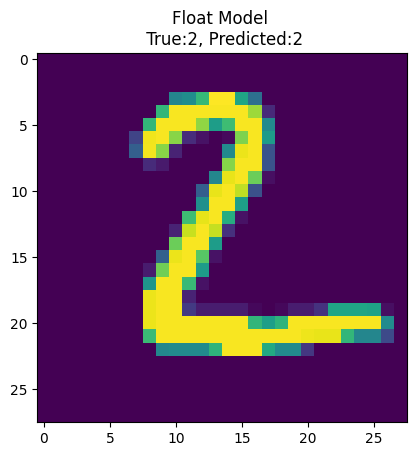

In [13]:
test_model(tflite_model_file, test_image_index, model_type="Float")

And test the quantized model:

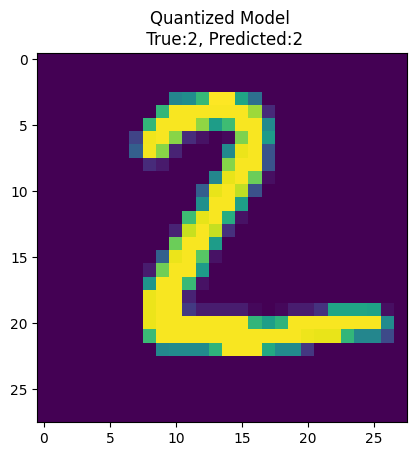

In [14]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

### Evaluate the models on all images

Now let's run both models using all the test images we loaded at the beginning of this tutorial:

In [15]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

Evaluate the float model:

In [16]:
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 97.9700% (Number of test samples=10000)


Evaluate the quantized model:

In [17]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 97.9000% (Number of test samples=10000)


So you now have an integer quantized a model with almost no difference in the accuracy, compared to the float model.

To learn more about other quantization strategies, read about [TensorFlow Lite model optimization](https://www.tensorflow.org/lite/performance/model_optimization).